# PeerDAS Simulation

## TODOs

- [ ] Add attacker nodes
- [ ] Increase simulation runs
- [ ] Improve sample selection
- [ ] Simulate more real peer distribution
- [ ] Simulate gossipsub
- [ ] Simulate more real node capacity
- [ ] Stats of different parameter range
- [ ] Add other simulation targets


In [67]:
# %pip install pandas
# %pip install matplotlib
# %pip install "networkx==3.1"
# %pip install "scipy==1.11.2"

## Configurations

In [68]:
# Constants
BLOB_SIZE = 4096 * 32  # bytes

# Simulation
# The graph only makes sense if there are only few nodes
DRAW_NETWORK_GRAPH = False
SIMULATION_RUNS = 10


class Config:
    #
    # Data
    #
    MAX_BLOBS_PER_BLOCK = 256  # Full danksharding

    @property
    def DATA_PER_SLOT(self):
        return self.MAX_BLOBS_PER_BLOCK * BLOB_SIZE * 4  # including the extension

    NUMBER_OF_ROWS = 32  # Number of rows in the 2D data array
    NUMBER_OF_COLUMNS = 32  # Number of columns in the 2D data array

    @property
    def DATA_PER_ROW(self):
        # In bytes
        return self.DATA_PER_SLOT / self.NUMBER_OF_ROWS

    @property
    def DATA_PER_COLUMN(self):
        # In bytes
        return self.DATA_PER_SLOT / self.NUMBER_OF_COLUMNS

    @property
    def DATA_PER_SAMPLE(self):
        # In bytes
        return self.DATA_PER_SLOT / (self.NUMBER_OF_COLUMNS * self.NUMBER_OF_ROWS)

    #
    # Custody
    #
    SAMPLES_PER_SLOT = 70  # Number of samples per slot
    CUSTODY_REQUIREMENT = 2  # Minimum number of both rows and columns an honest node custodies and serves samples from

    @property
    def CUSTODY_REQUIREMENT_SUPERNODE(self):
        return min(self.NUMBER_OF_ROWS, self.NUMBER_OF_COLUMNS)

    #
    # Capacity
    #
    SAMPLING_DUE_SECOND = 4  # seconds, the time for a node to sample
    BANDWIDTH_UPLINK_NORMAL = 100 * 1000 * 1000 / 8  # Mbps -> bytes/second
    BANDWIDTH_UPLINK_SUPERNODE = BANDWIDTH_UPLINK_NORMAL * 10  # bytes/second, supernode has better bandwidth

    @property
    def NORMAL_CAPACITY(self):
        # The bytes of data a normal node can serve in a sampling period
        return self.BANDWIDTH_UPLINK_NORMAL * self.SAMPLING_DUE_SECOND
    
    @property
    def SUPERNODE_CAPACITY(self):
        # The bytes of data a supernode can serve in a sampling period
        return self.BANDWIDTH_UPLINK_SUPERNODE * self.SAMPLING_DUE_SECOND

    #
    # Networking
    #
    NUMBER_OF_NODES = 5000  # Number of nodes in the network
    PERCENTAGE_OF_SUPERNODE = 1  # Percentage of supernodes in the network
    PERCENTAGE_OF_DISHONEST = 10  # Percentage of dishonest nodes in the network

    @property
    def PERCENTAGE_OF_NORMAL(self):
        # Percentage of normal nodes in the network
        return 100 - self.PERCENTAGE_OF_SUPERNODE - self.PERCENTAGE_OF_DISHONEST

    TARGET_NUMBER_OF_PEERS = 70  # Target number of peers each node has
    TARGET_NUMBER_OF_PEERS_SUPERNODE = TARGET_NUMBER_OF_PEERS * 2  # Target number of peers each supernode has; more peers than normal nodes

## Helpers

In [69]:
import enum
import random
from typing import Sequence, Any


rng = random.Random(5566)


class LineType(enum.Enum):
    ROW = 0
    COLUMN = 1


## Peer connections
class Node:
    id: int
    peers: set[int] = set()
    custody_rows: set[int] = []
    custody_cols: set[int] = []
    is_honest: bool = True
    is_supernode: bool = False
    target_peers: int = 0
    capacity: float = 0

    def __init__(self, config: Config, id: int) -> None:
        self.id = id
        self.target_peers = config.TARGET_NUMBER_OF_PEERS
        self.capacity = config.NORMAL_CAPACITY
        self.is_honest = rng.randint(1, 100) > config.PERCENTAGE_OF_DISHONEST
        if self.is_honest:
            if rng.randint(1, 100) <= config.PERCENTAGE_OF_SUPERNODE:
                self.is_supernode = True
                self.target_peers = config.TARGET_NUMBER_OF_PEERS_SUPERNODE
                self.capacity = config.SUPERNODE_CAPACITY

    def set_custody(self, config: Config, epoch: int, custody_row_log: dict[set[int]], custody_col_log: dict[set[int]]) -> None:
        if self.is_supernode:
            custody_size = config.CUSTODY_REQUIREMENT_SUPERNODE
        elif self.is_honest:
            custody_size = config.CUSTODY_REQUIREMENT
        else:
            # TODO
            # Dishoenst nodes custody less than CUSTODY_REQUIREMENT
            # custody_size = rng.randint(0, CUSTODY_REQUIREMENT - 1)
            custody_size = 0

        self.custody_rows, self.custody_cols = get_custody_rows_cols(config, self.id, epoch, custody_size=custody_size)
        for row in self.custody_rows:
            custody_row_log[row].add(self.id)
        for col in self.custody_cols:
            custody_col_log[col].add(self.id)


#
# Custody helpers
#

def cycle(seq: Sequence[Any], start: int) -> Any:
    while True:
        yield seq[start]
        start = (start + 1) % len(seq)


def get_custody_lines(config: Config, node_id: int, epoch: int, custody_size: int, line_type: LineType) -> list[int]:
    bound = config.NUMBER_OF_ROWS if line_type else config.NUMBER_OF_COLUMNS
    all_items = list(range(bound))
    line_index = (node_id + epoch) % bound
    iterator = cycle(all_items, line_index)
    return [next(iterator) for _ in range(custody_size)]


def get_custody_rows_cols(config: Config, node_id: int, epoch: int, custody_size: int) -> tuple[list[int], list[int]]:
    rows = get_custody_lines(config, node_id, epoch, custody_size, line_type=LineType.ROW)
    cols = get_custody_lines(config, node_id, epoch, custody_size, line_type=LineType.COLUMN)

    assert len(rows) == len(cols) == custody_size
    return rows, cols


def get_node_ids_by_line_index(config: Config, epoch: int, line_index: int, line_type: LineType) -> list[int]:
    # NOTE: not in-use in this simulation, but demonstrates how to get node ids by line_index of a row or column
    for node_id in range(config.NUMBER_OF_NODES):
        custody_items = get_custody_lines(config, node_id, epoch, custody_size=config.CUSTODY_REQUIREMENT, line_type=line_type)
        if line_index in custody_items:
            yield node_id


def get_custodian_peers(nodes: Sequence[Node], node_id: int, line_index: int,
                        custody_log: dict[set[int]]) -> Sequence[int]:
    """
    Get the peers that custody the given ``line_index`` line of a row or column.
    """
    return nodes[node_id].peers.intersection(custody_log[line_index])


## Simulation assumptions and logic

### Setting

In [70]:
config_demo = Config()

print(f'Data per slot:\t{config_demo.DATA_PER_SLOT / 1000} KB')
print(f'Data per row:\t{config_demo.DATA_PER_ROW / 1000} KB')
print(f'Data per column:\t{config_demo.DATA_PER_COLUMN / 1000} KB')
print(f'Data per sample:\t{config_demo.DATA_PER_SAMPLE / 1000} KB')
required_downlink_bandwidth = (config_demo.DATA_PER_SAMPLE * config_demo.SAMPLES_PER_SLOT) / config_demo.SAMPLING_DUE_SECOND / 1000 / 1000 * 8
print(f'Required downlink bandwidth per slot with {config_demo.SAMPLING_DUE_SECOND} seconds sampling time:\t{required_downlink_bandwidth} Mbps')


Data per slot:	134217.728 KB
Data per row:	4194.304 KB
Data per column:	4194.304 KB
Data per sample:	131.072 KB
Required downlink bandwidth per slot with 4 seconds sampling time:	18.350080000000002 Mbps


### P2P network topology

In [71]:
# Set all nodes with naive topology and custody
def set_peers(nodes: Sequence[Node]) -> None:
    """
    Set peers for each node. Naive implementation.
    """
    for n in nodes:
        # TODO: set different distribution
        if len(n.peers) < n.target_peers:
            selectable_node_ids = set(p.id for p in nodes if len(p.peers) < p.target_peers)
            selectable_peers = selectable_node_ids.difference(n.peers.union(set([n.id])))
            new_peers = set()
            need_peer_count = n.target_peers - len(n.peers)
            if need_peer_count > 0:
                new_peers = rng.sample(list(selectable_peers), k=min(need_peer_count, len(selectable_peers)))
            n.peers = n.peers.union(new_peers)
            for peer_id in new_peers:
                # NOTE: DO NOT USE nodes[peer_id].peers.add(n.id)  <-- side effect!
                nodes[peer_id].peers = nodes[peer_id].peers.union(set([n.id]))


def get_nodes(config: Config, epoch: int, node_count: int, custody_row_log: dict[set[int]], custody_col_log: dict[set[int]]) -> Sequence[Node]:
    """
    Initialize nodes with peers and their custodies.
    """
    all_nodes = [Node(id=id, config=config) for id in range(node_count)]
    set_peers(all_nodes)
    for node in all_nodes:
        node.set_custody(config, epoch, custody_row_log, custody_col_log)

    return all_nodes

# Temparary log for simulation stats
custody_row_log_demo = {i: set() for i in range(config_demo.NUMBER_OF_ROWS)}
custody_col_log_demo = {i: set() for i in range(config_demo.NUMBER_OF_COLUMNS)}

all_nodes_demo = get_nodes(config=config_demo, epoch=0, node_count=config_demo.NUMBER_OF_NODES, custody_row_log=custody_row_log_demo, custody_col_log=custody_col_log_demo)

In [72]:
import networkx as nx


if DRAW_NETWORK_GRAPH:
    g = nx.Graph()
    for node in all_nodes_demo:
        g.add_node(node.id)
    for node in all_nodes_demo:
        for peer_id in node.peers:
            g.add_edge(node.id, peer_id)

    nx.draw(g, node_size=2, alpha=0.5, width=0.1)

In [73]:
import pandas as pd


stats = []
for node in all_nodes_demo:
    stats.append({
        "node.id": node.id,
        "len(peers)": len(node.peers),
        "len(custody_rows)": len(node.custody_rows),
        "len(custody_cols)": len(node.custody_cols),
    })

average_peer_count = sum(x["len(peers)"] for x in stats) / len(stats)
print(f"Average peer count: {average_peer_count}")
if any(x["len(peers)"] == 0 for x in stats):
    print("WARNING: Some nodes have no peers!")

average_custody_count = sum((x["len(custody_rows)"] + x["len(custody_rows)"]) for x in stats) / len(stats)
print(f"Average custody lines (rows + columns): {average_custody_count}")

stats = pd.DataFrame(stats)
pd.set_option('display.max_rows', 20)
stats

Average peer count: 70.64
Average custody lines (rows + columns): 4.1424


,node.id,len(peers),len(custody_rows),len(custody_cols)
0,0,70,2,2
1,1,70,0,0
2,2,70,2,2
3,3,70,0,0
4,4,70,2,2
...,...,...,...,...
4995,4995,70,2,2
4996,4996,66,2,2
4997,4997,70,2,2
4998,4998,70,0,0


In [74]:
#### Supernode

In [75]:
import pandas as pd

stats = []

for node in all_nodes_demo:
    if node.is_supernode:
        stats.append({
            "node.id": node.id,
            "len(peers)": len(node.peers),
        })
print(f'Number of supernodes: {len(stats)} ({len(stats) / len(all_nodes_demo) * 100}%)')
stats = pd.DataFrame(stats)
pd.set_option('display.max_rows', 20)
stats

Number of supernodes: 46 (0.9199999999999999%)


,node.id,len(peers)
0,102,140
1,121,140
2,188,140
3,194,140
4,196,140
...,...,...
41,4448,140
42,4457,140
43,4586,140
44,4728,140


### Sampling

Each node does:
1. pseudo-randomly choose the sample point.
2. Compute the peer list of peers who should have downloaded the given lines.
3. Request the peer can provide the sample.

In [76]:
# Sampling

def sample_peer(config: Config, nodes: Sequence[Node], peer_id: int, line_index: int, line_type: LineType) -> bool:
    # If the peer has no enough capacity, it can not serve the sample
    nodes[peer_id].capacity -= config.DATA_PER_SAMPLE
    if nodes[peer_id].capacity < 0:
        return False

    return (line_index in nodes[peer_id].custody_rows) if line_type else (line_index in nodes[peer_id].custody_cols)


def sample_by_line(config: Config, nodes: Sequence[Node], node_id: int, line_index: int, line_type: LineType, custody_log: dict[set[int]]) -> bool:
    """
    Sample a peer that custodies the given ``line_index``.
    """
    custodian_peers = get_custodian_peers(nodes, node_id, line_index=line_index, custody_log=custody_log)

    if len(custodian_peers) == 0:
        return False

    # Choose a random peer that custodies the given line
    peer_id = rng.choice(list(custodian_peers))
    return sample_peer(config, nodes, peer_id, line_index=line_index, line_type=line_type)


def sample(config: Config, nodes: Sequence[Node], custody_row_log: dict[set[int]], custody_col_log: dict[set[int]]):
    sample_results = []  # 1 if all samples are successful, 0 if one of it has failed
    reconstructions = []  # 1 if node is able to recover the data with the sampled rows/cols, 0 if unable
    all_samples = list(range(config.NUMBER_OF_ROWS * config.NUMBER_OF_COLUMNS))

    # TODO: parallelize it
    for node_id in range(len(nodes)):
        rows_uncovered , cols_uncovered, samples_uncovered = ([] for _ in range(3))
        rows_covered = [0 for _ in range(config.NUMBER_OF_ROWS)]
        cols_covered = [0 for _ in range(config.NUMBER_OF_COLUMNS)]

        success = True
        # Select `SAMPLES_PER_SLOT` samples
        selected_samples = rng.sample(all_samples, config.SAMPLES_PER_SLOT)
        for s in selected_samples:
            # Search some samples by rows, some by columns
            if rng.randint(0, 1):
                # Find by rows
                row_index = s // config.NUMBER_OF_COLUMNS
                line_success = sample_by_line(config, nodes, node_id, line_index=row_index, line_type=LineType.ROW, custody_log=custody_row_log)
                if line_success:
                    rows_covered[row_index] = 1
                else:
                    success = False
            else:
                # Find by columns
                col_index = s % config.NUMBER_OF_COLUMNS
                line_success = sample_by_line(config, nodes, node_id, line_index=col_index, line_type=LineType.COLUMN, custody_log=custody_col_log)
                if line_success:
                    cols_covered[col_index] = 1
                else:
                    success = False

        sample_results.append(1) if success else sample_results.append(0)

        rows_uncovered.append(sum(1 if x == 0 else 0 for x in rows_covered))
        cols_uncovered.append(sum(1 if x == 0 else 0 for x in cols_covered))
        samples_uncovered.append(rows_uncovered[-1] * cols_uncovered[-1])

        # If less than 1/4 of the row/col is unavailable, the node can not reconstruct the data
        if samples_uncovered[-1] > config.NUMBER_OF_ROWS * config.NUMBER_OF_COLUMNS / 4:
            reconstructions.append(0)
        else:
            reconstructions.append(1)

    return sample_results, reconstructions


sample_results, reconstructions = sample(config_demo, all_nodes_demo,
                                          custody_row_log=custody_row_log_demo, custody_col_log=custody_row_log_demo)

In [77]:

import pandas as pd

stats = [{
    "no_failed_sample": sum(sample_results) / len(sample_results),
    "has_failed_sample": 1 - sum(sample_results) / len(sample_results),
    "reconstructable": sum(reconstructions) / len(reconstructions),
    "not_reconstructable": 1 - sum(reconstructions) / len(reconstructions),
    "nodes_no_enough_bandwidth": len([n for n in all_nodes_demo if n.capacity < 0]),
}]

stats = pd.DataFrame(stats)
stats

,no_failed_sample,has_failed_sample,reconstructable,not_reconstructable,nodes_no_enough_bandwidth
0,0.8824,0.1176,1.0,0.0,0


### Reconstruction

#### Reconstruct with all peers

The nodes that are able to reconstruct the data by requesting all its peers: 

In [78]:
def reconstruct(config: Config, nodes: Sequence[None]) -> list[int]:
    # TODO: consider capacity

    rows_uncovered = []
    columns_uncovered = []
    samples_uncovered = []
    for node in nodes:
        rows_covered = [0 for _ in range(config.NUMBER_OF_ROWS)] 
        cols_covered = [0 for _ in range(config.NUMBER_OF_COLUMNS)]
        # Look for all peers
        for peer in node.peers:
            for row in nodes[peer].custody_rows:
                rows_covered[row] = 1
            for col in nodes[peer].custody_cols:
                cols_covered[col] = 1

    rows_uncovered.append(sum(1 if x == 0 else 0 for x in rows_covered))
    columns_uncovered.append(sum(1 if x == 0 else 0 for x in cols_covered))
    samples_uncovered.append(rows_uncovered[-1] * columns_uncovered[-1])

    if samples_uncovered[-1] > config.NUMBER_OF_ROWS * config.NUMBER_OF_COLUMNS / 4:
        reconstructions.append(0)

    return reconstructions

best_reconstructions = reconstruct(config_demo, all_nodes_demo)

In [79]:
import pandas as pd

stats = [{
    "best_reconstructable": sum(best_reconstructions) / len(best_reconstructions),
    "not_reconstructable": 1 - sum(best_reconstructions) / len(best_reconstructions),
}]
stats = pd.DataFrame(stats)
stats

,best_reconstructable,not_reconstructable
0,1.0,0.0


## Simulation results

### 1. Node count

In [80]:
node_counts = [5000, 7500, 10000]
all_sample_results, all_reconstructions = ({} for _ in range(2))

for node_count in node_counts:
    config = Config()
    config.NUMBER_OF_NODES = node_count

    all_sample_results[node_count] = []
    all_reconstructions[node_count] = []
    for run in range(SIMULATION_RUNS):
        custody_row_log = {i: set() for i in range(config.NUMBER_OF_ROWS)}
        custody_col_log = {i: set() for i in range(config.NUMBER_OF_COLUMNS)}

        nodes = get_nodes(config, epoch=0, node_count=node_count, custody_row_log=custody_row_log, custody_col_log=custody_col_log)
        sample_results, reconstructions = sample(config, nodes, custody_row_log=custody_row_log, custody_col_log=custody_col_log)

        all_sample_results[node_count].append(sample_results)
        all_reconstructions[node_count].append(reconstructions)


In [81]:
node_counts_stats_sample_results, node_counts_stats_reconstructions = ([] for _ in range(2))

for node_count, sample_results_per_node_count in all_sample_results.items():
    reconstructions = all_reconstructions[node_count]
    flatten_success = [x for y in sample_results_per_node_count for x in y ]
    flatten_reconstructions = [x for y in reconstructions for x in y ]
    average_success_rate = sum(flatten_success) / len(flatten_success)
    average_reconstructable_rate = sum(flatten_reconstructions) / len(flatten_reconstructions)
    node_counts_stats_sample_results.append({
        "node_count": node_count,
        "len(flatten)": len(flatten_success),
        "average_all_successful_sample_rate": average_success_rate,
        "average_reconstructable_rate": average_reconstructable_rate,
    })

node_counts_results = pd.DataFrame(node_counts_stats_sample_results)

node_counts_results

,node_count,len(flatten),average_all_successful_sample_rate,average_reconstructable_rate
0,5000,50000,0.884480,0.999940
1,7500,75000,0.875547,0.999987
2,10000,100000,0.866430,0.999960


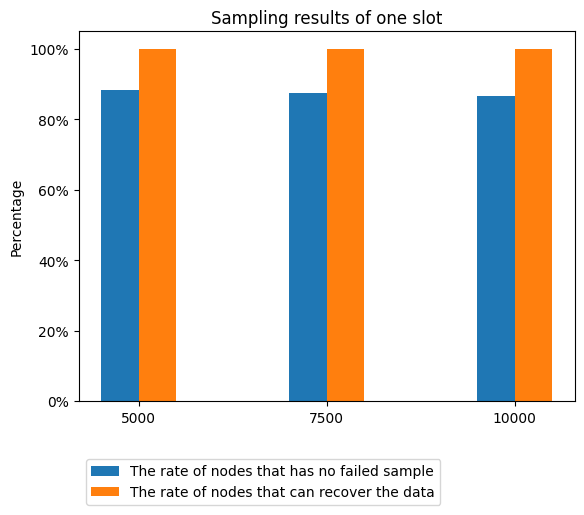

In [82]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# draw chart of stats_sample_results
fig, ax = plt.subplots()
x = np.arange(len(node_counts))
width = 0.2

ax.set_ylabel('Percentage')
ax.set_title('Sampling results of one slot')
rects1 = ax.bar(x - width / 2, node_counts_results['average_all_successful_sample_rate'], width, label='The rate of nodes that has no failed sample')
rects2 = ax.bar(x + width / 2, node_counts_results['average_reconstructable_rate'], width, label='The rate of nodes that can recover the data')

ax.set_xticks(x)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xticklabels(node_counts)
ax.legend(bbox_to_anchor=(0, -0.3, 0, 0.5), loc='lower left')
plt.show()

### 2. Capacity

In [83]:
all_sample_results, all_reconstructions, all_capacities = ({} for _ in range(3))

param_blobs_per_block = [128, 256, 512]

for blobs_per_block in param_blobs_per_block:
    config = Config()
    config.MAX_BLOBS_PER_BLOCK = blobs_per_block

    all_sample_results[blobs_per_block] = []
    all_reconstructions[blobs_per_block] = []
    all_capacities[blobs_per_block] = []
    for run in range(SIMULATION_RUNS):
        custody_row_log = {i: set() for i in range(config.NUMBER_OF_ROWS)}
        custody_col_log = {i: set() for i in range(config.NUMBER_OF_COLUMNS)}

        nodes = get_nodes(config, epoch=0, node_count=config.NUMBER_OF_NODES, custody_row_log=custody_row_log, custody_col_log=custody_col_log)
        sample_results, reconstructions = sample(config, nodes, custody_row_log=custody_row_log, custody_col_log=custody_col_log)

        all_sample_results[blobs_per_block].append(sample_results)
        all_reconstructions[blobs_per_block].append(reconstructions)
        all_capacities[blobs_per_block].append([int(n.capacity < 0) for n in nodes])

In [ ]:
capacities_stats_sample_results = []

for blobs_per_block, sample_results in all_sample_results.items():
    reconstructions = all_reconstructions[blobs_per_block]
    capacities = all_capacities[blobs_per_block]
    flatten_success = [x for y in sample_results for x in y]
    flatten_reconstructions = [x for y in reconstructions for x in y]
    flatten_capacities = [x for y in capacities for x in y]
    average_success_rate = sum(flatten_success) / len(flatten_success)
    average_reconstructable_rate = sum(flatten_reconstructions) / len(flatten_reconstructions)
    average_capacities = sum(1 for c in flatten_capacities if c > 0) / SIMULATION_RUNS
    capacities_stats_sample_results.append({
        "blobs_per_block": blobs_per_block,
        "len(flatten)": len(flatten_success),
        "average_all_successful_sample_rate": average_success_rate,
        "average_reconstructable_rate": average_reconstructable_rate,
        "#nodes_no_enough_bandwidth": average_capacities,
    })

capacities_results = pd.DataFrame(capacities_stats_sample_results)

capacities_results

,blobs_per_block,len(flatten),average_all_successful_sample_rate,average_recoverable_rate,#nodes_no_enough_bandwidth
0,128,50000,0.54820,0.88766,41.8
1,256,50000,0.54616,0.87982,45.6
2,512,50000,0.54776,0.87142,48.7
